In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [ ]:
# 1. Cargar el dataset de imágenes (sin etiquetas)
def load_images(folder_path, img_size=(64, 64), max_images=None):
    images, filenames = [], []
    count = 0
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            img = Image.open(os.path.join(folder_path, fname)).convert('L').resize(img_size)
            images.append(np.array(img).flatten())
            filenames.append(fname)
            count += 1
            if max_images and count >= max_images:
                break
    return np.array(images), np.array(filenames)

# Cambia esta ruta a la carpeta donde tienes tus imágenes (todas en una sola carpeta)
folder_path = r"C:\Users\Felix\Downloads\all_images"

X, filenames = load_images(folder_path, img_size=(64, 64), max_images=12000)

print(f"Total de imágenes cargadas: {X.shape[0]} (features por imagen: {X.shape[1]})")
assert X.shape[0] > 10000, "Se requieren al menos 10,000 imágenes para cumplir el reto."


Total de imágenes cargadas: 12000 (features por imagen: 4096)


In [9]:
# 2. Inicializar etiquetas a -1 (sin etiquetas)
y = np.full(X.shape[0], -1)

In [10]:
# 3. Seleccionar aleatoriamente un pequeño conjunto para etiquetar (simulando el trabajo humano)
np.random.seed(42)
n_labeled_samples = 20
labeled_indices = np.random.choice(X.shape[0], n_labeled_samples, replace=False)
# Simulamos dos clases, puedes cambiar el rango si tienes más clases reales
y[labeled_indices] = np.random.randint(0, 2, size=n_labeled_samples)

print(f"Imágenes etiquetadas manualmente (simuladas): {n_labeled_samples}")

Imágenes etiquetadas manualmente (simuladas): 20


In [11]:
# 4. Aprendizaje semisupervisado (Label Spreading)
label_prop = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2)
label_prop.fit(X, y)
y_semi = label_prop.transduction_

print("Aprendizaje semisupervisado completado. Ejemplo de etiquetas inferidas:", y_semi[:30])


Aprendizaje semisupervisado completado. Ejemplo de etiquetas inferidas: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
# 4. Aprendizaje semisupervisado
label_prop = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.2)
label_prop.fit(X, y)
y_semi = label_prop.transduction_

print("Aprendizaje semisupervisado completado. Ejemplo de etiquetas inferidas:", y_semi[:30])

# 5. Aprendizaje activo
X_labeled = X[y_semi != -1]
y_labeled = y_semi[y_semi != -1]
X_unlabeled = X[y_semi == -1]
y_unlabeled = y_semi[y_semi == -1]

if X_unlabeled.shape[0] == 0:
    print("¡Advertencia! No quedan ejemplos sin etiqueta tras el aprendizaje semisupervisado. El aprendizaje activo NO puede continuar.")
else:
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_labeled,
        y_training=y_labeled,
        query_strategy=uncertainty_sampling,
    )

    print("Comenzando aprendizaje activo...")
    n_queries = 10
    for i in range(n_queries):
        if X_unlabeled.shape[0] == 0:
            print("No quedan ejemplos no etiquetados en el pool para el aprendizaje activo.")
            break
        query_idx, query_instance = learner.query(X_unlabeled)
        label = y_unlabeled[query_idx][0]
        learner.teach(X_unlabeled[query_idx], [label])
        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
        print(f"Iteración {i+1}: imágenes restantes en el pool activo: {X_unlabeled.shape[0]}")

    print("Aprendizaje activo finalizado.")

Aprendizaje semisupervisado completado. Ejemplo de etiquetas inferidas: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
¡Advertencia! No quedan ejemplos sin etiqueta tras el aprendizaje semisupervisado. El aprendizaje activo NO puede continuar.


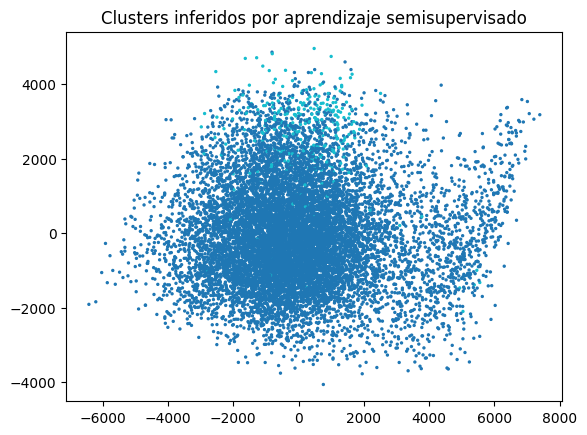

In [14]:
# (Opcional) Visualización rápida con PCA
if X.shape[0] < 20000:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    X_pca = PCA(n_components=2).fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_semi, s=2, cmap='tab10')
    plt.title("Clusters inferidos por aprendizaje semisupervisado")
    plt.show()